In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, VGG, VGG16_Weights
from torchvision import transforms
from scipy import ndimage
from PIL import Image as pil
import numpy as np
from tqdm.notebook import tqdm
import ast
import cv2

In [4]:
class UnNormalize(transforms.Normalize):
    def __init__(self,mean,std,*args,**kwargs):
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model = model.to(DEVICE)

In [8]:
model_conv_modules = [m for m in list(model.features) if type(m) is torch.nn.modules.conv.Conv2d]

In [9]:
model_conv_modules

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [10]:
model_modules = [m for m in list(model.features)]

In [11]:
[(i,m) for i,m in enumerate(model_modules)]

[(0, Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (1, ReLU(inplace=True)),
 (2, Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (3, ReLU(inplace=True)),
 (4,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (5, Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (6, ReLU(inplace=True)),
 (7, Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (8, ReLU(inplace=True)),
 (9,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (10, Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (11, ReLU(inplace=True)),
 (12, Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (13, ReLU(inplace=True)),
 (14, Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (15, ReLU(inplace=True)),
 (16,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (17, Conv2d(256, 512, kernel_size=(3, 3

In [12]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
normalize_imagenet_inv = UnNormalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

Старт оптимизации начнем с некоторого рандомного изображения

In [13]:
input_img = np.random.randn(224, 224, 3)
min_img = input_img.min(axis=0, keepdims=True).min(axis=1, keepdims=True)
max_img = input_img.max(axis=0, keepdims=True).max(axis=1, keepdims=True)
input_img = (255*(input_img-min_img)/(max_img-min_img)).astype(np.uint8)

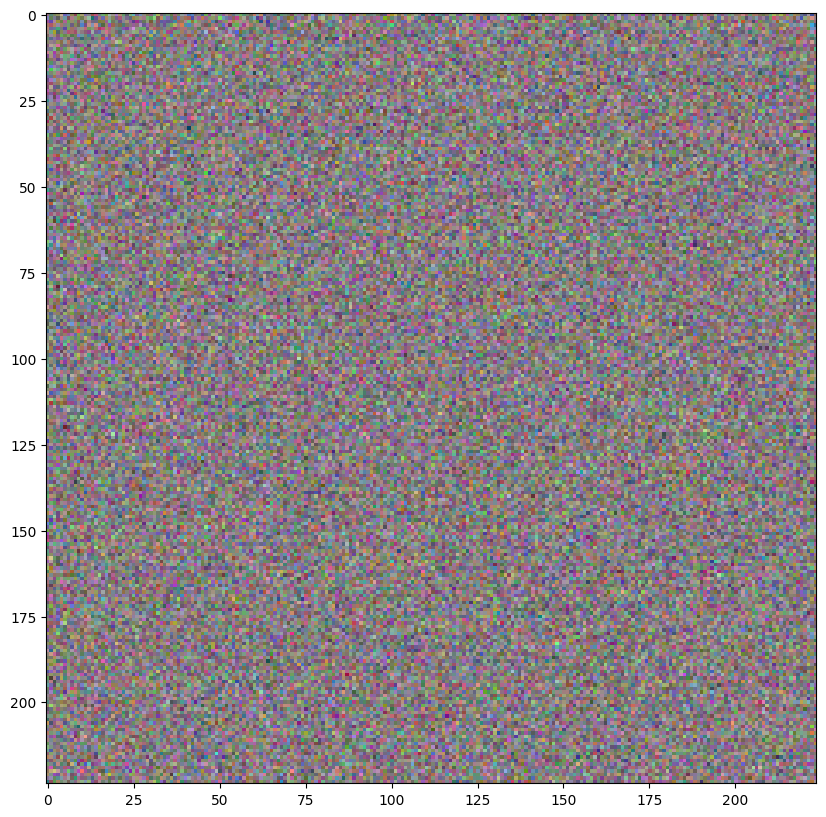

In [14]:
plt.imshow(input_img)

In [15]:
def make_torch_tensor_imagenet_normalized(img_np_float):
    x = transforms.ToPILImage()(img_np_float)
    x = transforms.ToTensor()(x)
    x = normalize_imagenet(x)
    x = torch.unsqueeze(x, 0)
    return x

In [16]:
def transform_back(img_tensor):
    x = torch.squeeze(img_tensor)
    x = normalize_imagenet_inv(x)
    x = x.detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (255*(x-x.min())/(x.max()-x.min())).astype(np.uint8)
    return x

In [17]:
input_img_tensor = make_torch_tensor_imagenet_normalized(input_img)

In [18]:
input_img_tensor = input_img_tensor.to(DEVICE)

обязательно укажем `pytorch` вычислять градиенты по этому тензору

In [19]:
input_img_tensor = input_img_tensor.requires_grad_(True)

In [20]:
input_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [21]:
feature_num = 383

In [22]:
submodel = model

Прототипируем вычисления. Ниже мы их будет проводить итерационно, в цикле максимизации нужного нам признака.

In [23]:
hidden_features = submodel(input_img_tensor)

In [24]:
hidden_features.shape

torch.Size([1, 1000])

In [25]:
f1 = hidden_features[0,feature_num]

Средствами `pytorch` мы можем безболезненно считать градиенты только для скаляров. Поэтому сделаем из полученного признака скаляр - хотя бы осреднением.

In [26]:
f1.backward()

In [27]:
input_img_tensor.grad

tensor([[[[ 8.8010e-04, -1.1125e-04,  1.8444e-03,  ...,  3.6340e-03,
           -4.7538e-03,  3.3550e-03],
          [ 1.7471e-03, -3.7468e-03,  2.8256e-03,  ...,  9.9827e-04,
           -3.9459e-03, -1.6560e-04],
          [ 3.1851e-03, -5.2417e-04,  5.1100e-03,  ...,  1.1032e-02,
            8.8926e-03, -6.3238e-03],
          ...,
          [ 1.9662e-04,  7.4101e-04, -1.0289e-02,  ..., -9.7088e-03,
           -6.7158e-03, -2.5619e-03],
          [-2.4911e-03,  6.2418e-03, -4.9299e-03,  ..., -2.6952e-03,
           -4.3660e-03, -1.5413e-03],
          [-4.7393e-04,  1.0031e-03,  1.5102e-03,  ...,  5.7540e-03,
           -7.1915e-04,  3.8422e-05]],

         [[-5.6187e-04, -3.7027e-03, -4.0908e-03,  ...,  5.3844e-04,
           -8.0326e-03,  4.4902e-03],
          [ 4.4467e-04, -9.1332e-03, -5.4655e-03,  ..., -9.0179e-03,
           -9.1212e-03,  1.2925e-03],
          [ 7.8507e-04, -8.4186e-03, -3.0565e-03,  ...,  2.0097e-03,
            8.7219e-03, -7.0782e-03],
          ...,
     

In [28]:
input_img_tensor.grad = -input_img_tensor.grad

In [29]:
input_img_tensor.grad

tensor([[[[-8.8010e-04,  1.1125e-04, -1.8444e-03,  ..., -3.6340e-03,
            4.7538e-03, -3.3550e-03],
          [-1.7471e-03,  3.7468e-03, -2.8256e-03,  ..., -9.9827e-04,
            3.9459e-03,  1.6560e-04],
          [-3.1851e-03,  5.2417e-04, -5.1100e-03,  ..., -1.1032e-02,
           -8.8926e-03,  6.3238e-03],
          ...,
          [-1.9662e-04, -7.4101e-04,  1.0289e-02,  ...,  9.7088e-03,
            6.7158e-03,  2.5619e-03],
          [ 2.4911e-03, -6.2418e-03,  4.9299e-03,  ...,  2.6952e-03,
            4.3660e-03,  1.5413e-03],
          [ 4.7393e-04, -1.0031e-03, -1.5102e-03,  ..., -5.7540e-03,
            7.1915e-04, -3.8422e-05]],

         [[ 5.6187e-04,  3.7027e-03,  4.0908e-03,  ..., -5.3844e-04,
            8.0326e-03, -4.4902e-03],
          [-4.4467e-04,  9.1332e-03,  5.4655e-03,  ...,  9.0179e-03,
            9.1212e-03, -1.2925e-03],
          [-7.8507e-04,  8.4186e-03,  3.0565e-03,  ..., -2.0097e-03,
           -8.7219e-03,  7.0782e-03],
          ...,
     

In [30]:
opt = torch.optim.Adam([input_img_tensor], lr=0.5)

In [31]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

In [32]:
objective_history = []
input_snapshots = []
f1_history = []
f2_history = []

In [34]:
steps = 2000
each = 50

In [35]:
# Вариант для карт активации ранга 2 - вектор выходных значений оценки вероятности классов

with tqdm(total=steps) as pbar:
    for i in range(steps):
        features = submodel(input_img_tensor)
        f1 = features[0,feature_num]
        f2 = -(features[0,:feature_num].sum() + features[0,(feature_num+1):].sum())
        
        f1_np = float(f1.detach().cpu().numpy())
        f2_np = float(f2.detach().cpu().numpy())
        f1_history.append(f1_np)
        f2_history.append(f2_np)
        objective_history.append(f1_np+f2_np)
        
        loss = f1 + f2
        loss.backward()
        input_img_tensor.grad = -input_img_tensor.grad
        opt.step()
        if i % each == 0:
            input_snapshots.append(transform_back(input_img_tensor))
        lr_scheduler.step()
            
        opt.zero_grad()
        pbar.update(1)
        pbar.set_postfix({'step': i, 'f1': f1_np, 'f2': f2_np})

  0%|          | 0/2000 [00:00<?, ?it/s]

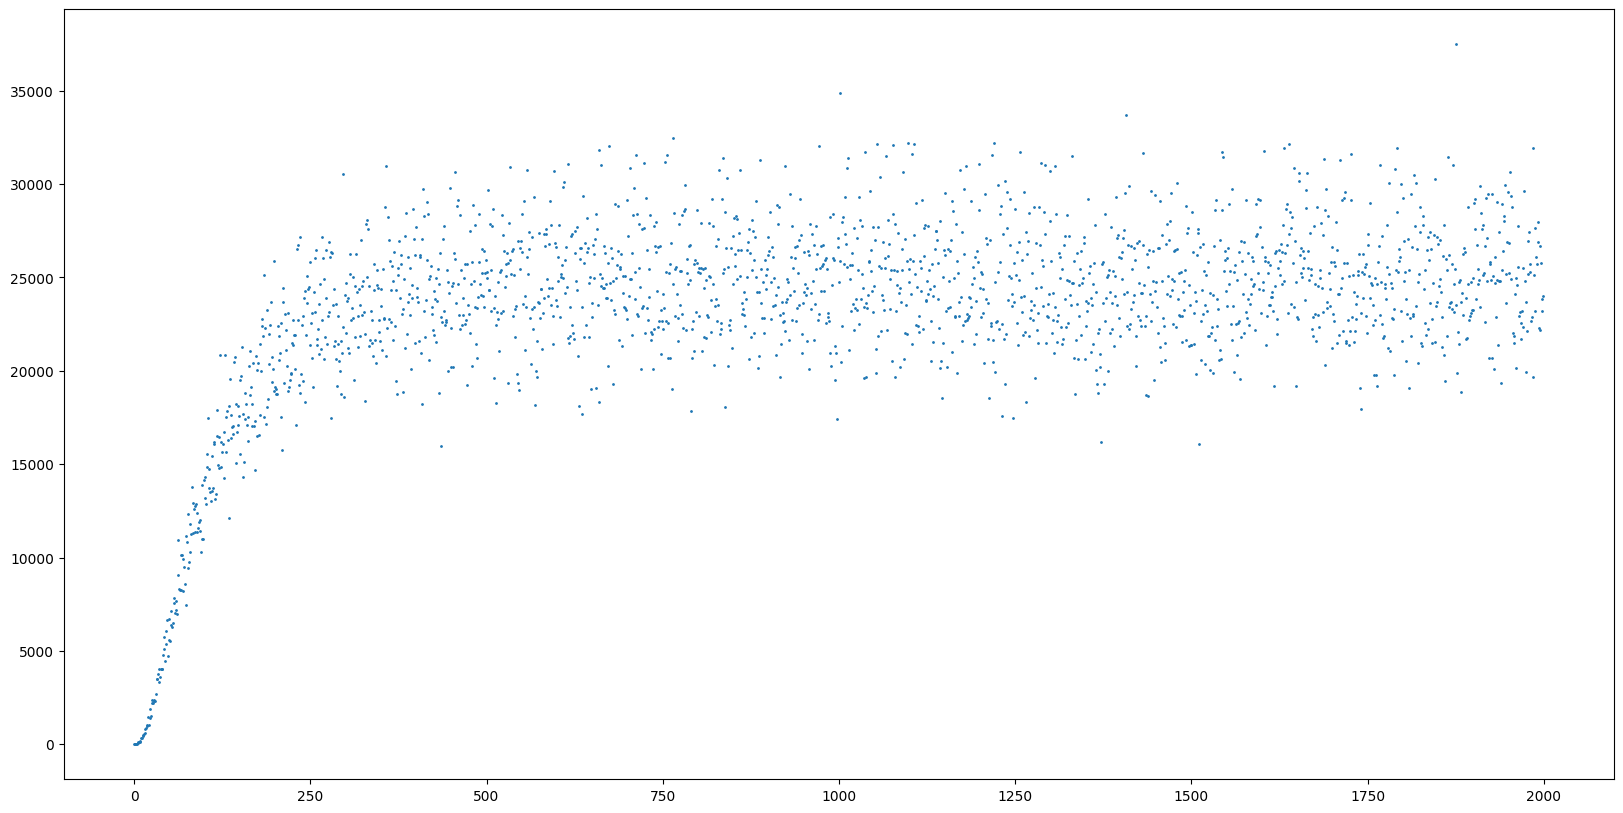

In [36]:
plt.scatter(np.arange(len(objective_history)), objective_history, s=1)

In [37]:
x = transform_back(input_img_tensor)

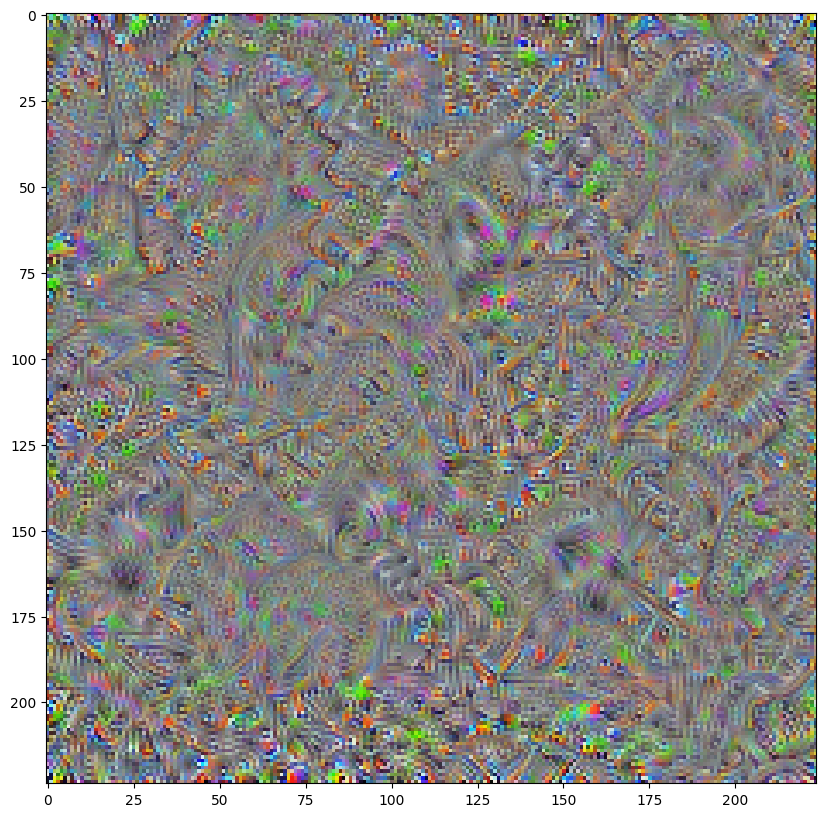

In [38]:
plt.imshow(x)

In [39]:
p = model(input_img_tensor)

Здесь p - т.н. "логиты" (logits) - значения, которые для оценки вероятностей классов нужно отнормировать с помощью ф-ии `Softmax`

In [41]:
nn.functional.softmax(p, dim=1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [42]:
nn.functional.softmax(p, dim=1)[0,383]

tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)

Отобразим области внимания (saliency map) для полученного изображения

In [46]:
y = model(input_img_tensor)[0, 383]

In [47]:
(grad, ) = autograd.grad(y, inputs=input_img_tensor, create_graph=False)

In [48]:
grad.shape

torch.Size([1, 3, 224, 224])

In [49]:
mp = np.abs(grad.cpu().detach())

In [50]:
def tensor2image(image_tensor: torch.Tensor) -> np.ndarray:
    image_tensor = image_tensor[0]  # выбираем единственный элемент
    image_tensor = image_tensor.permute((1, 2, 0))  # [channels, height, width] -> [height, width, channels]
    image_numpy = image_tensor.detach().cpu().numpy()  # конвертируем в numpy
    return image_numpy

In [51]:
def renormalize_image(x: np.ndarray) -> np.ndarray: 
    x = (x - np.min(x)) 
    x = x / np.max(x) * 255

    return x.astype(np.uint8)

In [52]:
saliency_map = tensor2image(mp).max(-1)
# image = renormalize_image(tensor2image(img_tensor))

In [53]:
image = renormalize_image(tensor2image(input_img_tensor))

In [54]:
heatmap = ndimage.gaussian_filter(saliency_map[:,:,None] , 8, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

In [55]:
heatmap = renormalize_image(heatmap) / 255

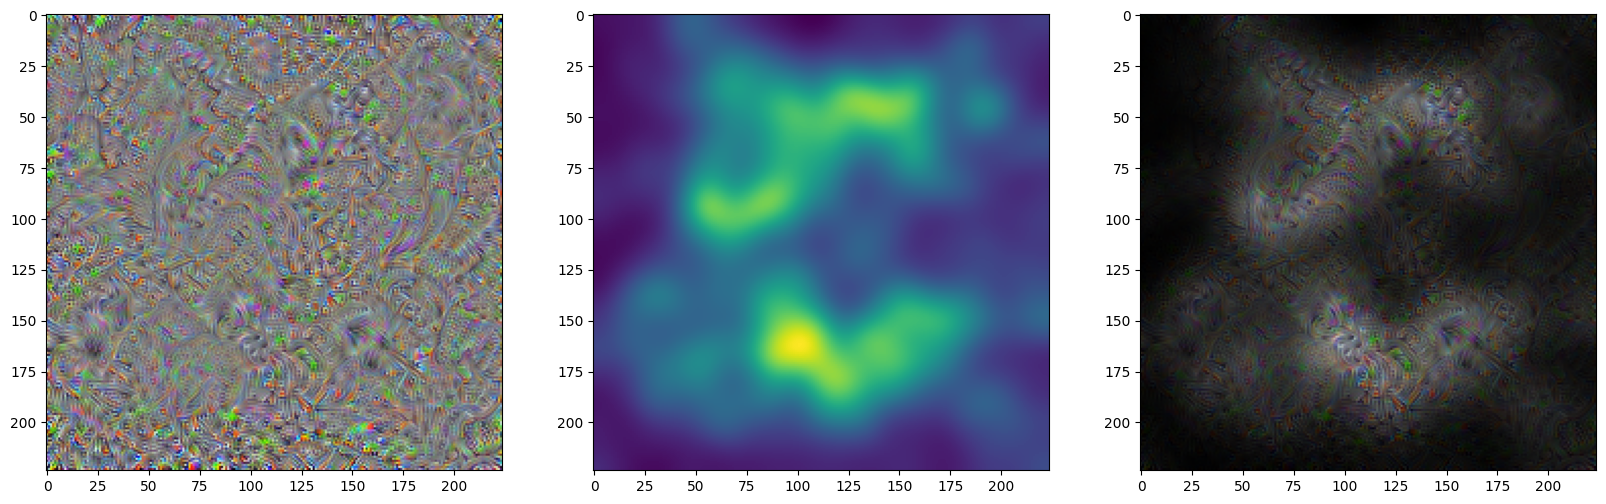

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.imshow(image)
ax = fig.add_subplot(1,3,2)
ax.imshow(heatmap[:,:,0])
ax = fig.add_subplot(1,3,3)
ax.imshow((image * heatmap).astype(np.uint8))

Итак, получили изображение, которое практически полностью "заполнено мадагаскарским котом".